# User Behaviour Analysis Based on Borrowing Dates

The aim of the notebook is to analyze user behavior based on the date of borrowing in order to create a kind of user profile. The following questions should be answered:
1. Do users have a routine when visiting the library? This initially refers to the day of the week on which users borrow items. Can consistency be identified on a particular day?
2. Can a more detailed user type be identified by including the time of day?

In [72]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [73]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [74]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



## Analysis of user routine and weekday consistency

### Collecting multiple loans into sessions
All loans by a user on a day make up a session.

In [75]:

df_sessions = borrowings.copy()
df_sessions["session_time"] = df_sessions[ISSUE_COL].dt.floor("D")

user_sessions = df_sessions.groupby([USER_ID_COL, "session_time"]).size().reset_index(name="items_borrowed")
user_sessions["weekday"] = user_sessions["session_time"].dt.day_name()


In [76]:
MIN_SESSIONS = 3
session_day_counts = user_sessions.groupby([USER_ID_COL, 'weekday']).size().unstack(fill_value=0)

# Top-Day-Percentage based on visits
session_consistency = (session_day_counts.max(axis=1) / session_day_counts.sum(axis=1)) * 100

frequent_user_mask = session_day_counts.sum(axis=1) >= MIN_SESSIONS
clean_consistency = session_consistency[frequent_user_mask]

print(f"Based on {len(clean_consistency)} users with >= {MIN_SESSIONS} visits.")
print(clean_consistency.describe())

Based on 15806 users with >= 3 visits.
count   15,806.0000
mean        42.7866
std         15.5018
min         16.6667
25%         31.8182
50%         38.4615
75%         50.0000
max        100.0000
dtype: float64


In [77]:
session_day_counts.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Benutzer-Systemnummer,,,,,,,
46,3,0,0,0,0,0,0
50,104,30,51,0,125,181,150
51,2,0,1,0,6,6,1
53,0,0,0,0,2,1,0
54,50,4,43,0,40,48,47


Quantify user routine by calculating the distribution of visits across weekdays and identifying the share of visits occurring on the most frequent day (Favorite Day Consistency)

The mean consistency of 42.8% indicates that, on average users perform nearly half of their borrowing sessions on their most preferred weekday. Compared to a theoretical random distribution of 20% (assuming 5 opening days), this could suggest a behavioral routine among frequent users

/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_31986/497821977.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


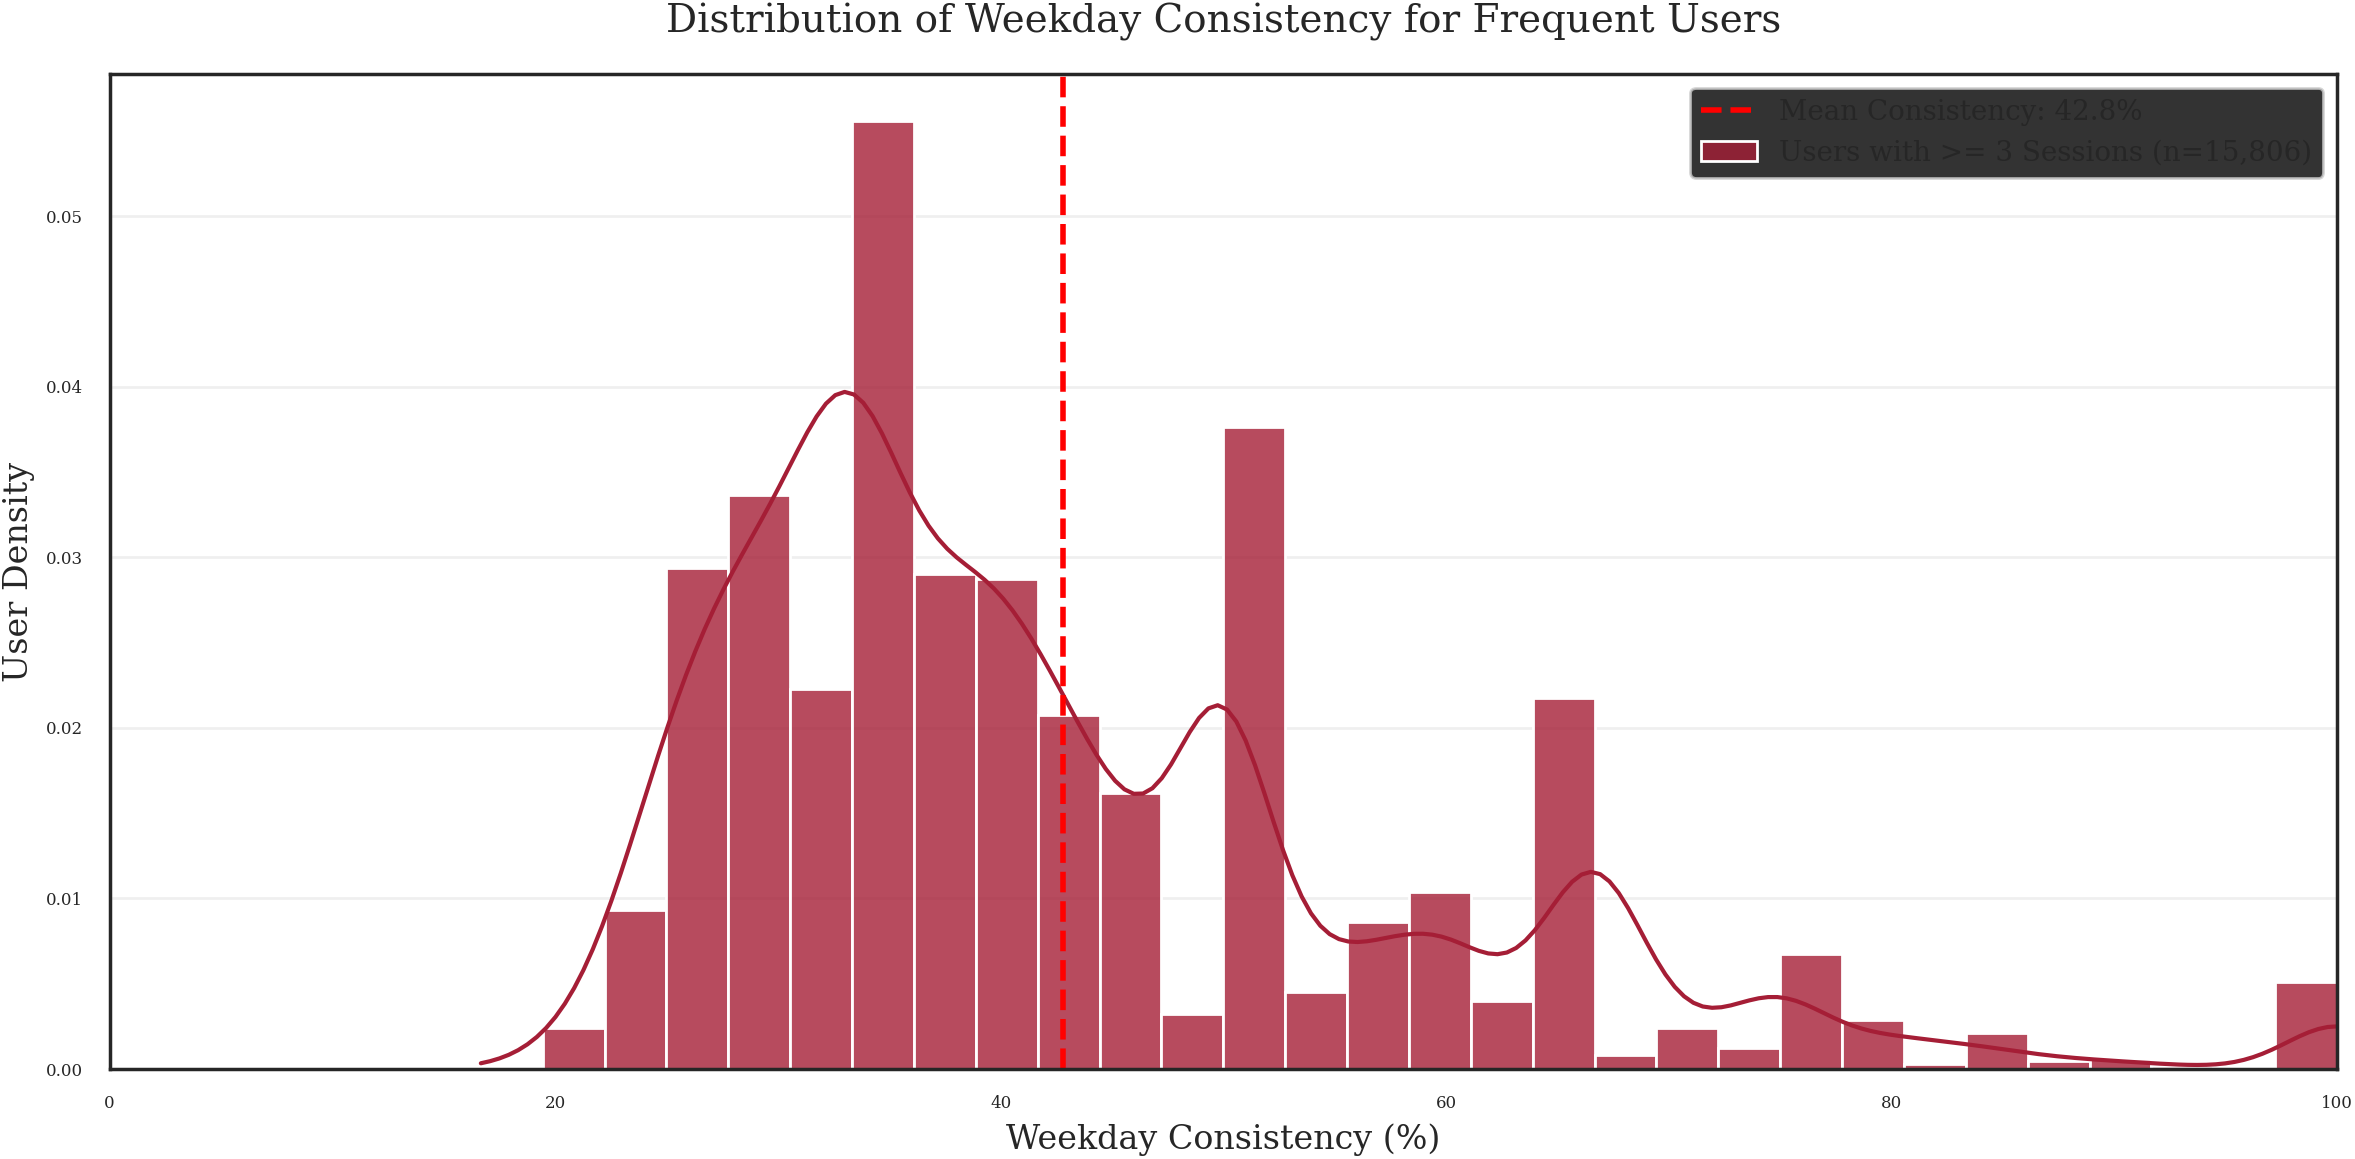

In [78]:

mean_val = clean_consistency.mean()

plt.figure(figsize=(12, 6))

sns.histplot(
    clean_consistency, 
    bins=30, 
    kde=True, 
    alpha=0.8, 
    label=f'Users with >= {MIN_SESSIONS} Sessions (n={len(clean_consistency):,})', 
    stat="density", 
    common_norm=False
)

plt.axvline(
    mean_val, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Mean Consistency: {mean_val:.1f}%'
)

plt.title('Distribution of Weekday Consistency for Frequent Users', fontsize=14, pad=15)
plt.xlabel('Weekday Consistency (%)', fontsize=12)
plt.ylabel('User Density', fontsize=12)

plt.xlim(0, 100)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

The distribution would also enable a possible grouping of users based on their consistency.


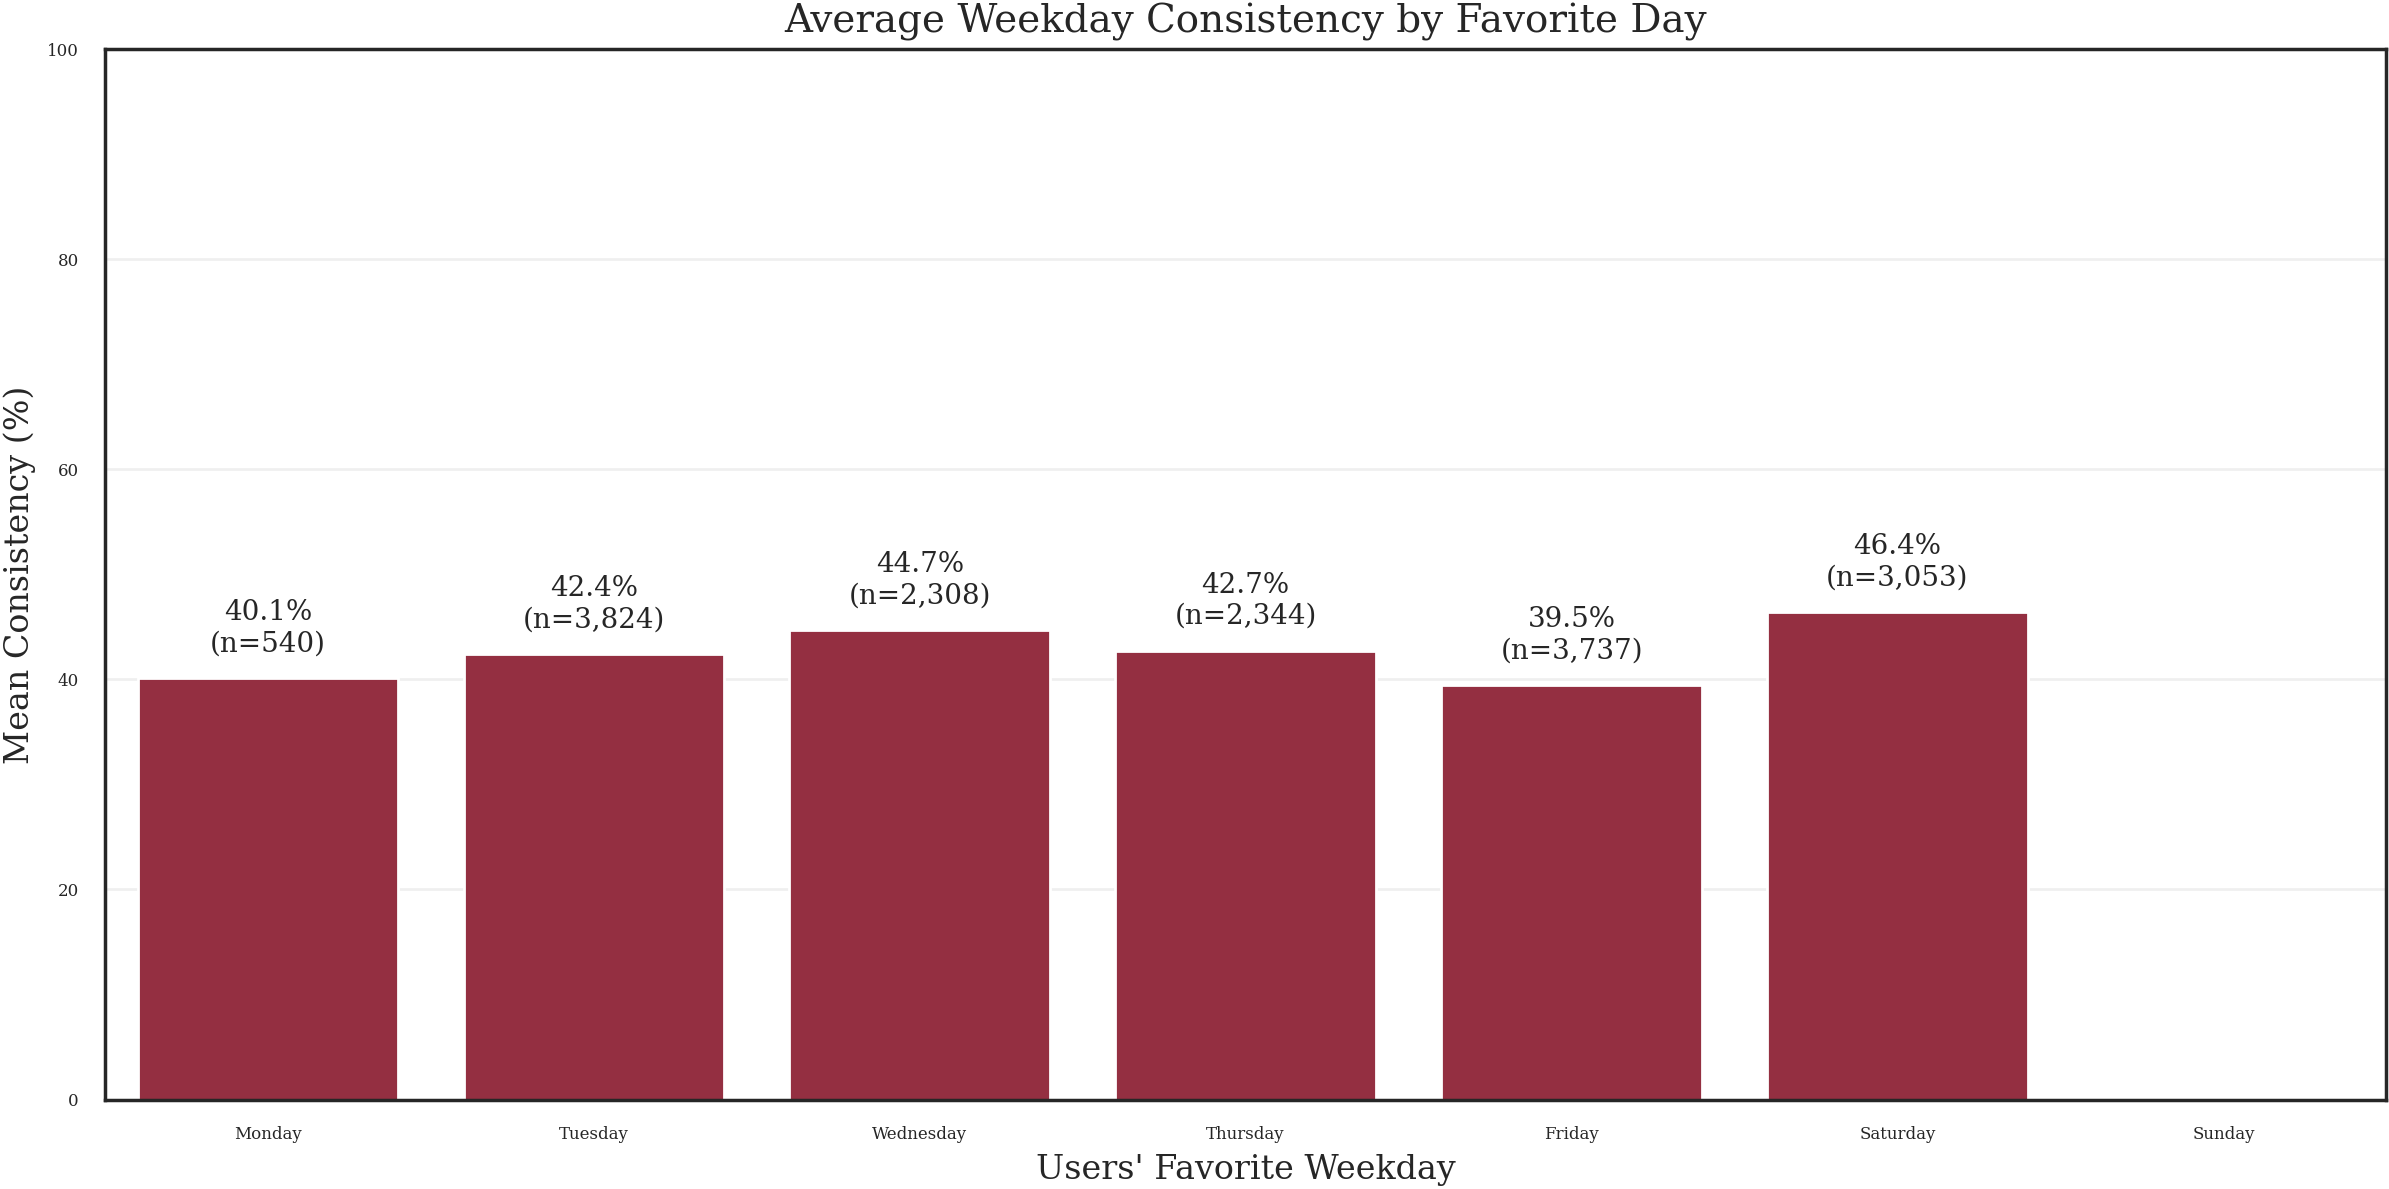

In [79]:
# Identify the favorite day for each user
favorite_days = session_day_counts.idxmax(axis=1)
favorite_days_df = favorite_days.to_frame(name='favorite_weekday')

# Merge with consistency metrics
consistency_comparison = favorite_days_df.merge(
    clean_consistency.to_frame(name='consistency'), 
    left_index=True, 
    right_index=True
)

#Calculate average consistency per favorite day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats = (
    consistency_comparison.groupby('favorite_weekday')['consistency']
    .agg(['mean', 'count'])
    .reindex(day_order)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=day_stats.index, 
    y=day_stats['mean'], 
)

plt.title('Average Weekday Consistency by Favorite Day', fontsize=14)
plt.xlabel('Users\' Favorite Weekday', fontsize=12)
plt.ylabel('Mean Consistency (%)', fontsize=12)
plt.ylim(0, 100)

for i, row in enumerate(day_stats.itertuples()):
    if not pd.isna(row.mean):
        plt.text(i, row.mean + 2, f"{row.mean:.1f}%\n(n={int(row.count):,})", 
                 ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

No matter what day of the week, users show a steady level of consistency.

## Analysis of borrowing time

Define sessions over time slots

In [80]:
df_time = borrowings.copy()
# Sort by user and time to calculate gaps correctly
df_time = df_time.sort_values(by=[USER_ID_COL, ISSUE_COL])

# Identify new sessions (gap > 30 minutes)
df_time['time_diff'] = df_time.groupby(USER_ID_COL)[ISSUE_COL].diff()
MAX_GAP = pd.Timedelta(minutes=30)
df_time['is_new_session'] = (df_time['time_diff'] > MAX_GAP) | (df_time['time_diff'].isna())
df_time['session_id'] = df_time.groupby(USER_ID_COL)['is_new_session'].cumsum()

# Aggregate to session level
user_sessions_fine = df_time.groupby([USER_ID_COL, 'session_id']).agg({
    ISSUE_COL: 'first',
    USER_CATEGORY_COL: 'first', # Added user category
    'late_bool': 'max',
    'is_new_session': 'size'    # Count rows per session
}).reset_index()

# Rename and create temporal features
user_sessions_fine = user_sessions_fine.rename(columns={'is_new_session': 'items_count'})
user_sessions_fine["weekday"] = user_sessions_fine[ISSUE_COL].dt.day_name()
user_sessions_fine["hour"] = user_sessions_fine[ISSUE_COL].dt.hour
user_sessions_fine["seconds_since_midnight"] = (
    user_sessions_fine[ISSUE_COL].dt.hour * 3600 +
    user_sessions_fine[ISSUE_COL].dt.minute * 60 +
    user_sessions_fine[ISSUE_COL].dt.second
)

user_sessions_fine["date"] = user_sessions_fine[ISSUE_COL].dt.date



In [81]:
user_sessions_fine.head()

,Benutzer-Systemnummer,session_id,Ausleihdatum/Uhrzeit,Benutzerkategorie,late_bool,items_count,weekday,hour,seconds_since_midnight,date
0,46,1.0000,2019-05-31 10:34:21,INS,True,1,Friday,10,38061,2019-05-31
1,46,2.0000,2023-03-10 10:17:05,INS,False,1,Friday,10,37025,2023-03-10
2,46,3.0000,2023-10-13 11:54:15,INS,False,1,Friday,11,42855,2023-10-13
3,50,1.0000,2019-01-02 00:00:00,MPA,False,4,Wednesday,0,0,2019-01-02
4,50,2.0000,2019-01-03 00:00:00,MPA,False,1,Thursday,0,0,2019-01-03


In [82]:
# Check for midnight outliers
midnight_sessions = user_sessions_fine[
    (user_sessions_fine[ISSUE_COL].dt.hour == 0) & 
    (user_sessions_fine[ISSUE_COL].dt.minute == 0) & 
    (user_sessions_fine[ISSUE_COL].dt.second == 0)
]

print(f"Sessions at exactly midnight: {len(midnight_sessions)}")

# Filter them out for the hourly analysis
user_sessions_clean = user_sessions_fine[~(
    (user_sessions_fine[ISSUE_COL].dt.hour == 0) & 
    (user_sessions_fine[ISSUE_COL].dt.minute == 0)
)].copy()

print(f"Remaining sessions for without midnight outliers: {len(user_sessions_clean)}")

user_counts = user_sessions_clean.groupby(USER_ID_COL).size()
frequent_user_ids = user_counts[user_counts >= MIN_SESSIONS].index

user_sessions_clean = user_sessions_clean[user_sessions_clean[USER_ID_COL].isin(frequent_user_ids)].copy()


print(f"Analyzing {len(frequent_user_ids)} users with at least {MIN_SESSIONS} visits and in total {len(user_sessions_clean)}.")


Sessions at exactly midnight: 7
Remaining sessions for without midnight outliers: 451632
Analyzing 15846 users with at least 3 visits and in total 444481.


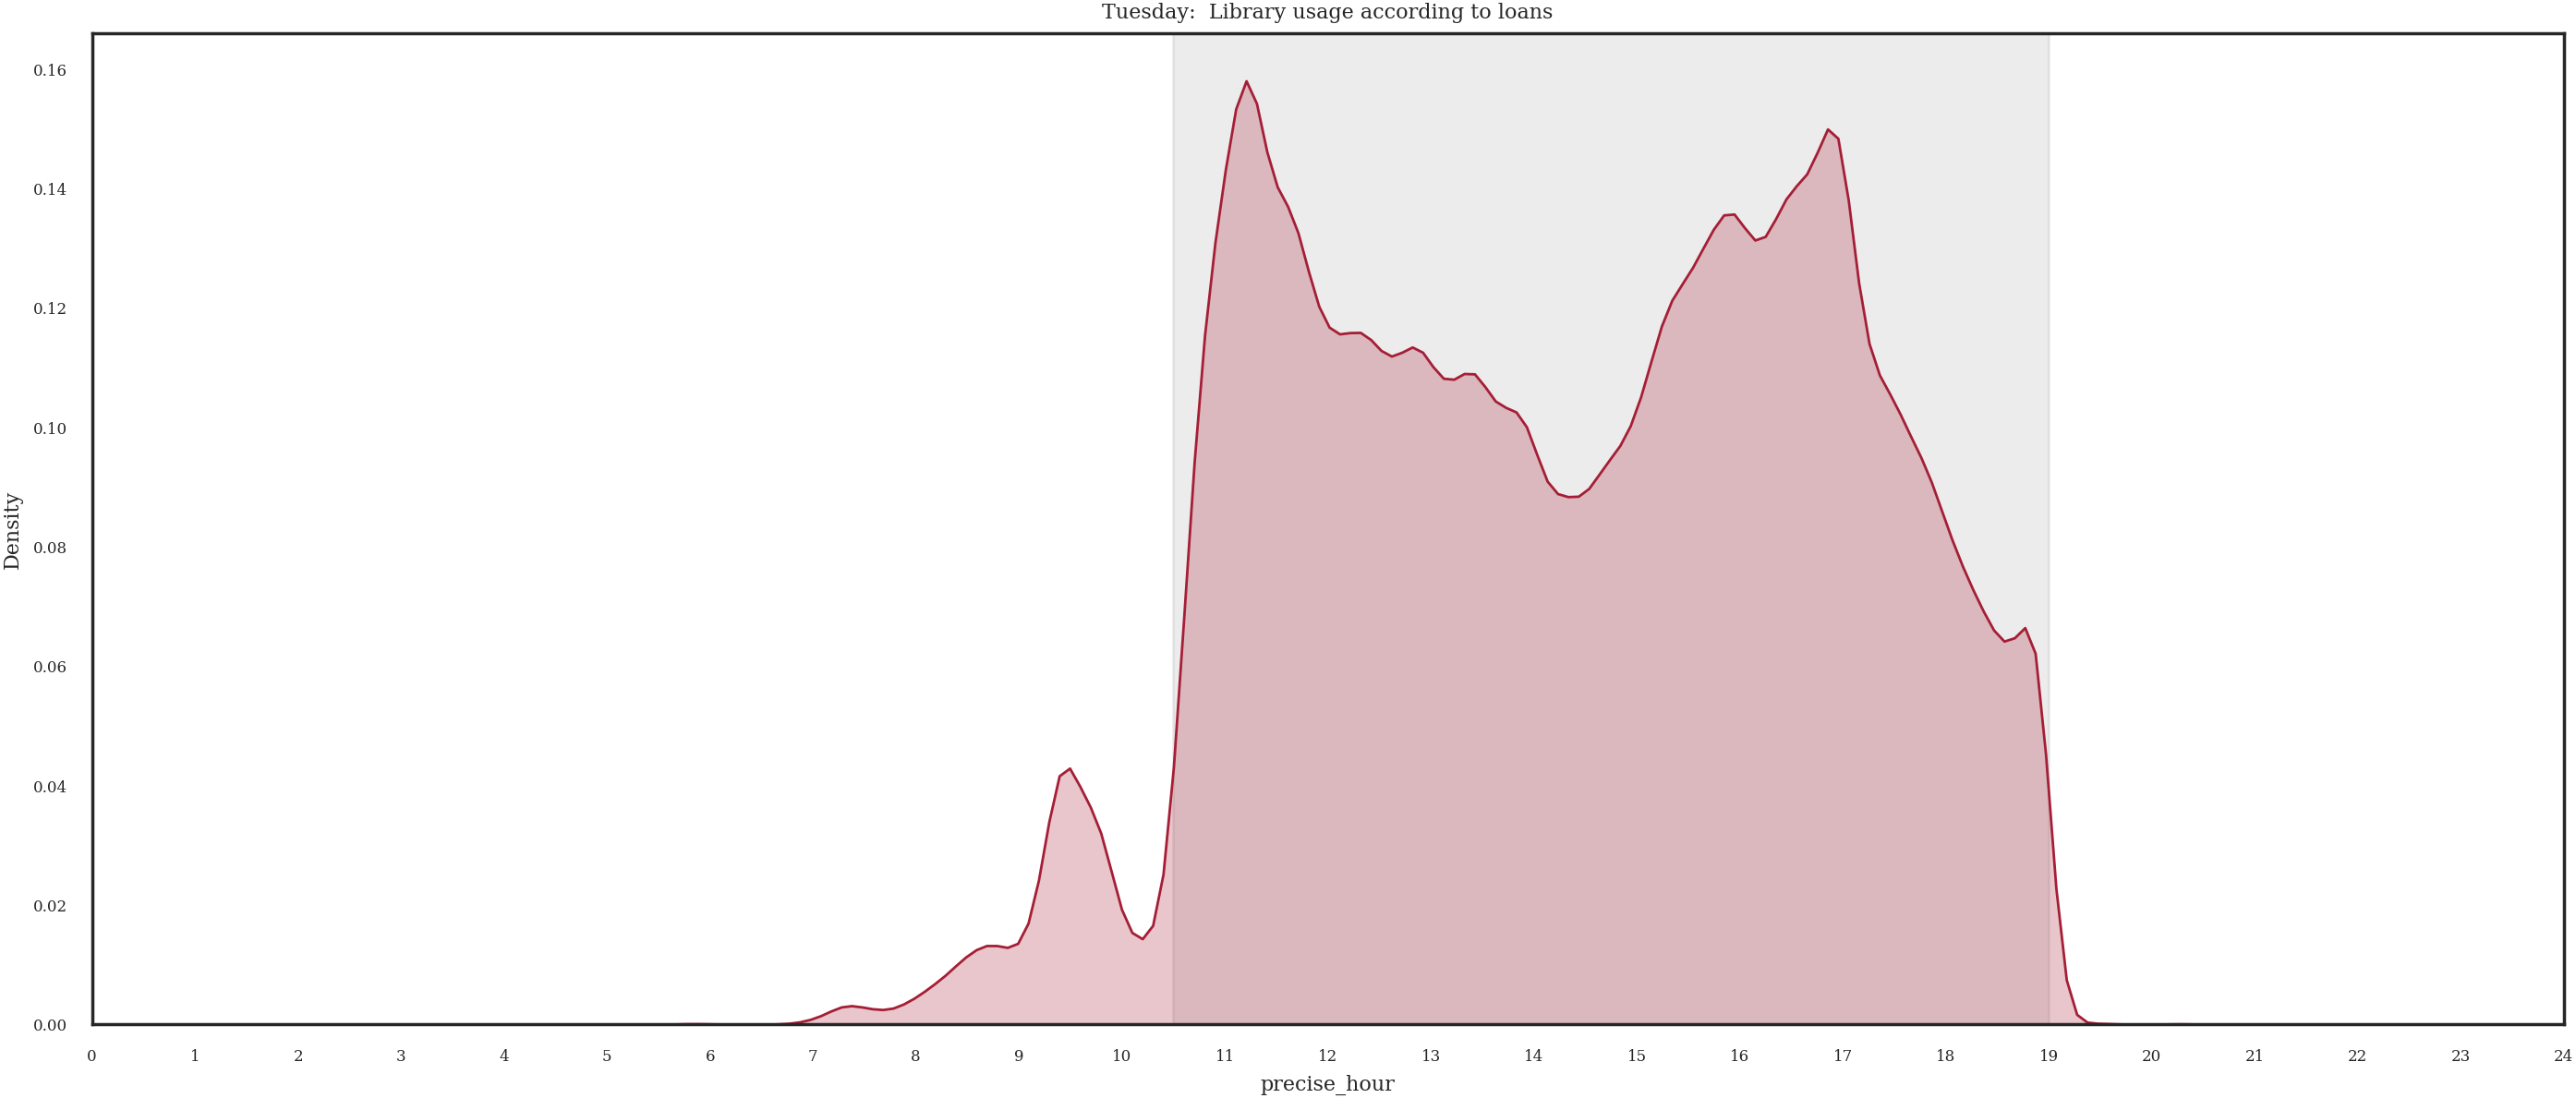

In [94]:

user_sessions_clean["precise_hour"] = user_sessions_clean["seconds_since_midnight"] / 3600

tuesday_data = user_sessions_clean[user_sessions_clean["weekday"] == "Tuesday"]

plt.figure(figsize=(14, 6))
plt.axvspan(10.5, 19.0, color='gray', alpha=0.15, label='Official Opening Hours')

sns.kdeplot(
    data=tuesday_data, 
    x="precise_hour", 
    fill=True, 
    bw_adjust=0.5, 
    label='Library Utilization Density'
)

plt.xlim(0, 24)
plt.xticks(range(0, 25))
plt.title("Tuesday:  Library usage according to loans")
plt.show()

In [84]:
# Calculate average time per user
user_time_behavior = user_sessions_clean.groupby(USER_ID_COL).agg({
    'hour': ['mean', 'std', 'count'], # Durchschnitt, Variabilität, Anzahl Besuche
    'weekday': lambda x: x.mode()[0] if not x.mode().empty else "Unknown" # Lieblingstag
})
user_time_behavior.columns = ['avg_hour', 'hour_spread', 'visit_count', 'fav_day']

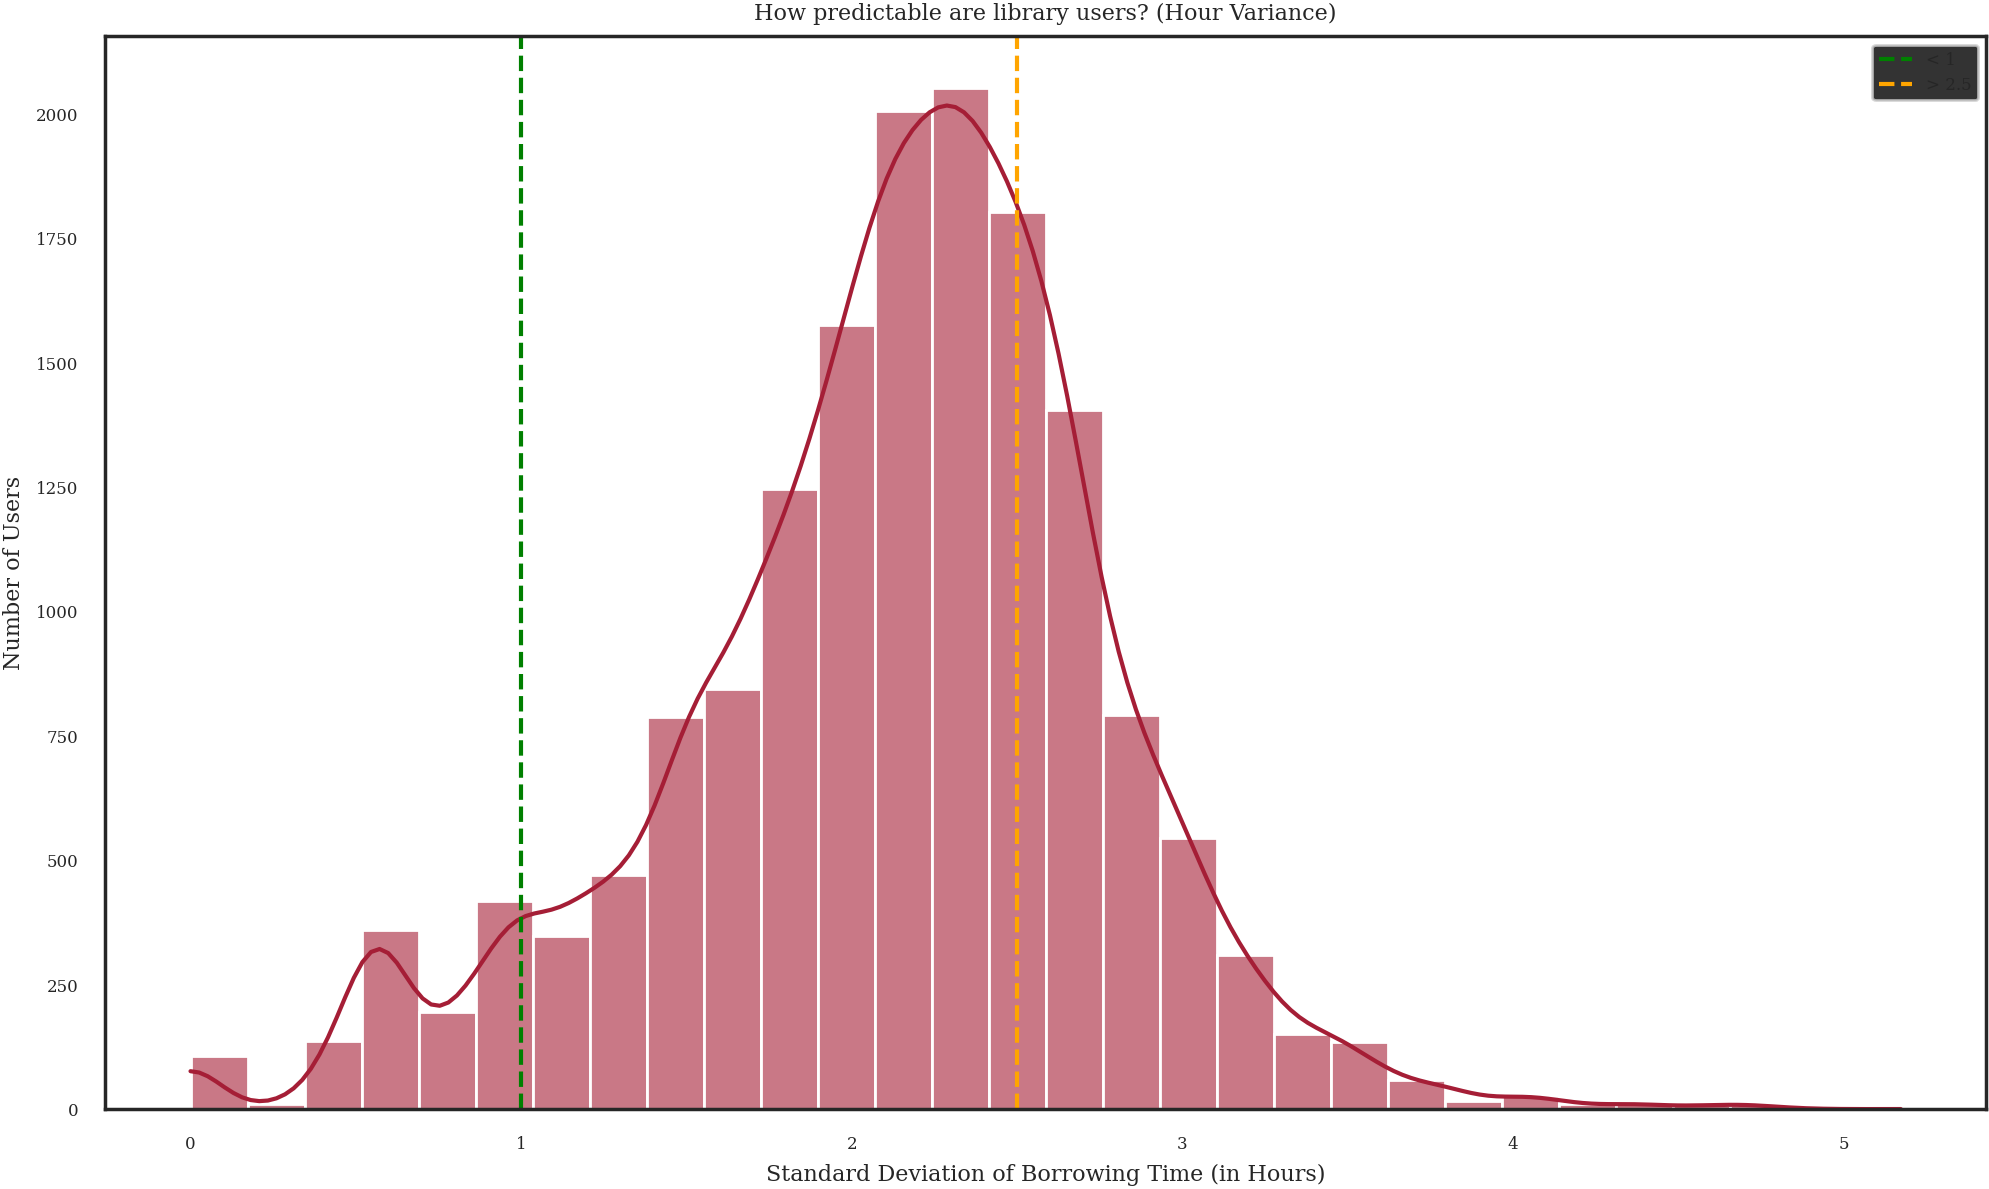

7.5% of users show high routine (±1 hour).
6.4% of users arrive at completely different times (>3h spread).


In [85]:
# only hour_spread
# Users with std = 0 are people who came exactly three times at exactly the same hour 
plt.figure(figsize=(10, 6))

sns.histplot(user_time_behavior['hour_spread'], bins=30, kde=True, alpha=0.6)

plt.axvline(1.0, color='green', linestyle='--', label='< 1')
plt.axvline(2.5, color='orange', linestyle='--', label='> 2.5')

plt.title("How predictable are library users? (Hour Variance)")
plt.xlabel("Standard Deviation of Borrowing Time (in Hours)")
plt.ylabel("Number of Users")
plt.legend()
plt.show()

low_var = (user_time_behavior['hour_spread'] <= 1.0).sum() / len(user_time_behavior['hour_spread']) * 100
high_var = (user_time_behavior['hour_spread'] > 3.0).sum() / len(user_time_behavior['hour_spread']) * 100

print(f"{low_var:.1f}% of users show high routine (±1 hour).")
print(f"{high_var:.1f}% of users arrive at completely different times (>3h spread).")

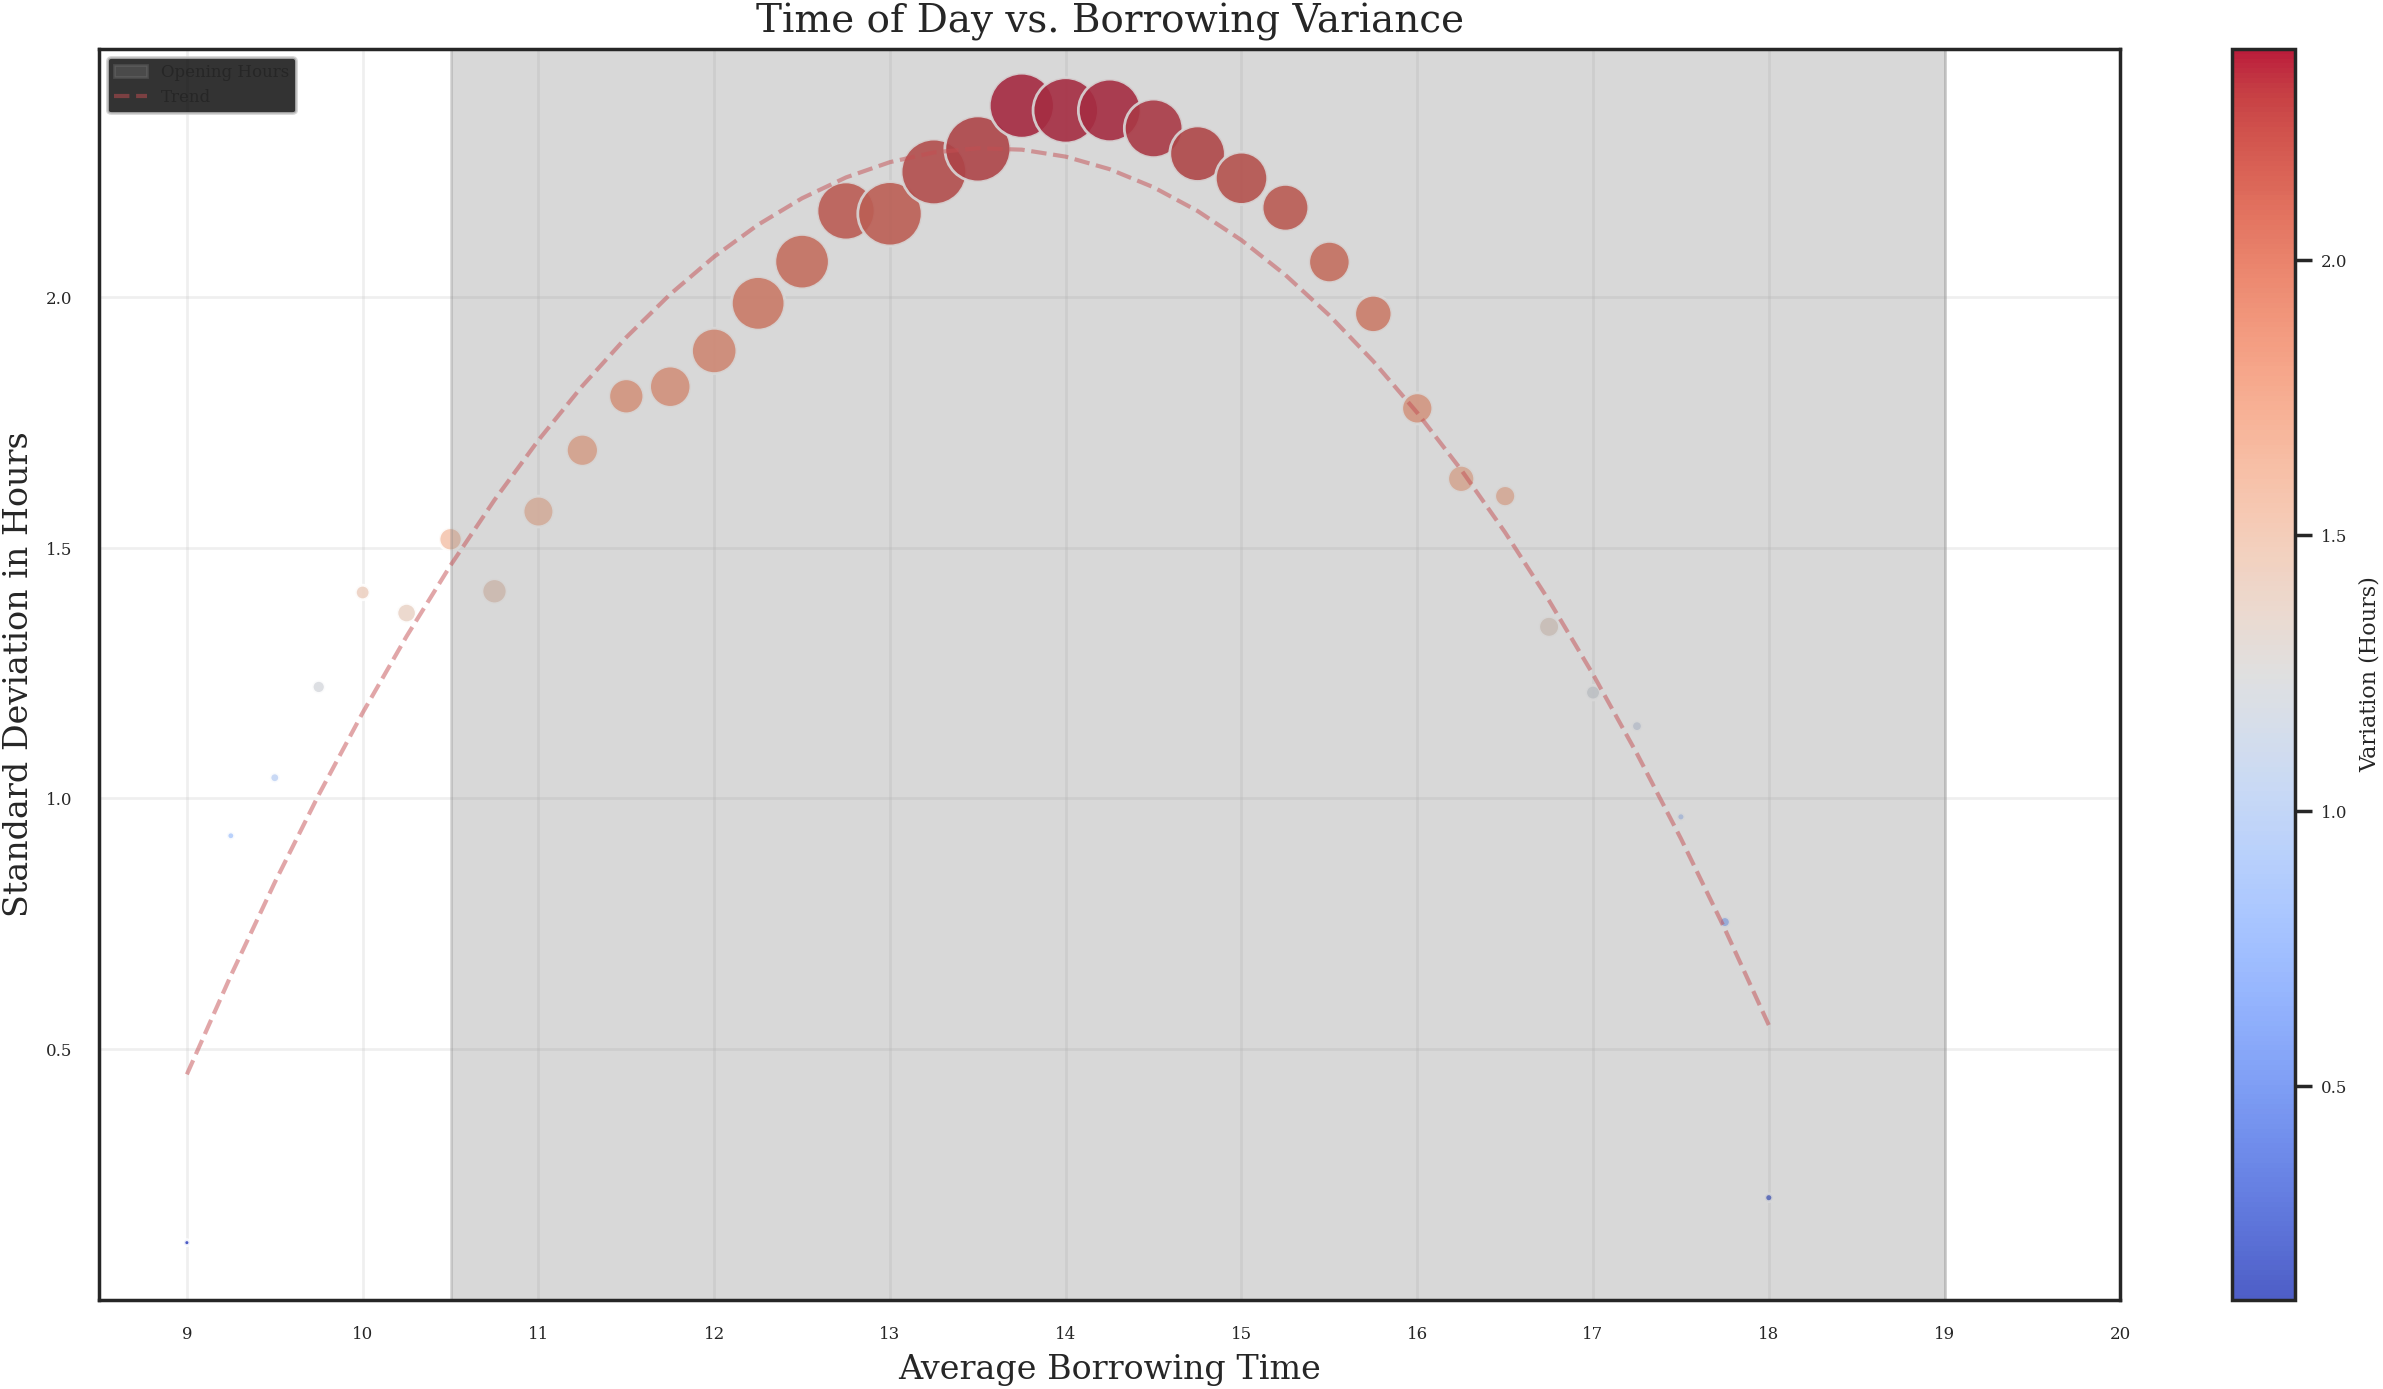

In [92]:


# Round average hour to 15-minute intervals (0.25h) for grouping
user_time_behavior['hour_bin'] = (user_time_behavior['avg_hour'] * 4).round() / 4

# Aggregate by time bin
stability_map = user_time_behavior.groupby('hour_bin').agg({
    'hour_spread': 'mean',
    'visit_count': 'count'
}).reset_index()

# Filter for relevant operational hours
stability_map = stability_map[(stability_map['hour_bin'] >= 9) & (stability_map['hour_bin'] <= 20)]

plt.figure(figsize=(12, 7))

# Create scatter plot: size = user volume, color = variance
scatter = plt.scatter(
    x=stability_map['hour_bin'],
    y=stability_map['hour_spread'],
    s=stability_map['visit_count'] * 0.5,
    c=stability_map['hour_spread'],
    cmap='coolwarm',
    alpha=0.9,
    edgecolors='w'
)

# Visualizing library opening context
plt.axvspan(10.5, 19.0, color='gray', alpha=0.3, label='Opening Hours')

# Add polynomial trend line (degree 2)
z = np.polyfit(stability_map['hour_bin'], stability_map['hour_spread'], 2)
p = np.poly1d(z)
plt.plot(stability_map['hour_bin'], p(stability_map['hour_bin']), "r--", alpha=0.5, label='Trend')

plt.title("Time of Day vs. Borrowing Variance", fontsize=14)
plt.xlabel("Average Borrowing Time", fontsize=12)
plt.ylabel("Standard Deviation in Hours", fontsize=12)
plt.xticks(range(9, 21))
plt.grid(axis='both', alpha=0.3)
plt.colorbar(scatter, label='Variation (Hours)')
plt.legend()

plt.show()